# Actual plots

## init

In [101]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

sns.set_theme(palette="colorblind", style="ticks")


initial_params_actual = {\
    "h" : {"thick": 0.0013, "thin": 0.0002},
    "E_lookup" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
    "E_lookup_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
    "E_lookup_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
}

initial_params = initial_params_actual.copy()

source_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\compare_magn_raw")

eval_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\compare_magn_raw\eval")
if not eval_dir.exists(): eval_dir.mkdir()

sources = source_dir.rglob("*.tif")
sources = list(sources)

order = ["80_S_thin", "80_S_thick", "80_H_thin", "80_H_thick"]

plot_out_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\compare_magn_plots")
if not plot_out_dir.exists(): plot_out_dir.mkdir()


## fit

In [2]:
from data_types import RidgeFit, RidgeFitMethod
from skimage.transform import rescale
# Extract ridge from images and store as csv
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile_style,fit_profile
from ridge_models import style_exact
# from scipy.signal import savgol_filter
import asyncio
import traceback

# https://stackoverflow.com/a/59385935/9173710

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

def _fit_calc(radial_coord, gamma, radius, popt, downscale_factor):
    radial_resized = rescale(radial_coord, downscale_factor, anti_aliasing=False)
    img_calc = np.zeros_like(radial_resized)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_resized[i,:], gamma, radius, *popt)
    return img_calc



@background
def fit_style(file):
    try:
        target_file = eval_dir / file.name
        ridge, image, circ_params, rim_binarized, r2, pixelscale = \
                extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
        yc,xc,r = circ_params
        # rolling average
        x_r, y_r = ridge
        # y_r = np.convolve(y_r, np.ones(10), 'same') / 10
        # y_r = savgol_filter(y_r, 500, 2)
        print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")
        df = pd.DataFrame({"x":x_r,"y":y_r})
        df.to_csv(target_file.with_suffix(".rdg"), sep=";")

        # fits: dict[str, RidgeFit] = fit_profile(target_file.with_suffix(".rdg"),models=["style"], **initial_params)
        fits: dict[str, RidgeFit] = fit_profile_style(target_file.with_suffix(".rdg"), **initial_params, fix_upsilon=False, fix_h=False)


        pickle.dump((yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge), open(target_file.with_suffix(".pkl"), "wb"))

    except Exception as e:
            print(str(e), traceback.format_exc())
            print(file)

futures = list()

sem = asyncio.Semaphore(4)
for file in sources:
    async with sem:
        futures.append(fit_style(file))

res = await asyncio.gather(*futures)


DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


c:\Users\krr38985\Documents\Python\ridge_evaluation\.venv\Lib\site-packages\skimage\measure\fit.py:308: UserWarning: Input does not contain enough significant data points.
  warn("Input does not contain enough significant data points.")


80_H_1_thin_magn_120mT_f.ome Center: (1399,1459) Radius: 915 R2: 0.998753200395987
80_H_1 - 0.6
Style:		R2 0.591
`gtol` termination condition is satisfied.

80_H_1_thick_magn_quer_f.ome Center: (1431,1369) Radius: 1080 R2: 0.997860110893641
80_H_1 - 0.7
Style:		R2 -3.904
`gtol` termination condition is satisfied.

80_H_1_thick_magn_120mT_f.ome Center: (1369,1407) Radius: 857 R2: 0.9744116763863646
80_H_1 - 0.5
80_S_1_thick_mag_220mT_f.ome Center: (1390,1382) Radius: 941 R2: 0.999527134334086
80_S_1 - 0.6
80_S_1_thick_magn_max_evap_f.ome Center: (1438,1421) Radius: 931 R2: 0.9995771105488449
Style:		R2 -1.668
`gtol` termination condition is satisfied.

80_S_1 - 0.6
Style:		R2 -0.065
`gtol` termination condition is satisfied.

Style:		R2 -0.004
`gtol` termination condition is satisfied.

80_H_1_thick_mag_220mT_f.ome Center: (1523,1392) Radius: 1048 R2: 0.9873326591837474
80_H_1 - 0.7
Style:		R2 -1.115
`gtol` termination condition is satisfied.

80_S_1_thick_magn_quer_f.ome Center: (1402,

## data conversion

In [102]:
from ridge_models import style_exact
df_dict = {}
df_list = []
model_dict = {}
for file in eval_dir.rglob("*.pkl"):
    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue

    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge = pickle.load(f)

    model = fits["style"]
    Fe, G, vol, th, _, magntype, *_ = Path(file).stem.split("_")
    if magntype == "380mT":
        magntype = "max"
    fit_x = np.linspace(model.x_values.min(), model.x_values.max(), 250)
    x,y = ridge
    y = y*1e6
    norm_x = x / model.radius
    # fit_y = 1e6*style_exact(x, model.gamma, model.radius, *model.popt)
    # fit_y_max = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_max"][f"{Fe}_{G}"], model.popt[2])
    # fit_y_min = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_min"][f"{Fe}_{G}"], model.popt[2])
    # fit_y_th = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup"][f"{Fe}_{G}"], model.popt[2])
    # df = pd.DataFrame({"x":x, "norm_x":norm_x, "y":y, "fit_y":fit_y, "fit_y_max":fit_y_max, "fit_y_min":fit_y_min, "fit_y_th":fit_y_th, "model":"style", "Fe":Fe, "G":G, "vol":vol, "th":th, "magn":magntype, "R2":model.r2})
    df = pd.DataFrame({"x":[x], "norm_x":[norm_x], "y":[y], "model":"style", "Fe":Fe, "G":G, "vol":vol, "th":th, "magn":magntype, "R2":model.r2})
    # df["rolling_y"] = df["y"].rolling(50,center=True).mean()
    # df["rolling_y_stdev"] = df["y"].rolling(50,center=True).std()
    # df_dict[f"{magntype}_{G}_{th}"] = df
    # model_dict[f"{magntype}_{G}_{th}"] = model

    df_list.append(df)
    print(f"{file.stem} - R2: {model.r2:.3f} - r {model.radius} - {model.popt}")

master_data = pd.concat(df_list, ignore_index=True)
master_data["magn"] = master_data["magn"].replace({"quer":"$\\rightarrow$120","120mT":"$\\uparrow$120","220mT":"$\\uparrow$220","max":"$\\uparrow$max"})
master_data["th"] = master_data["th"].replace({"thick":"$h =$ 1.2 mm","thin":"$h =$ 0.2 mm"})
master_data["G"] = master_data["G"].replace({"H":"17.5 kPa","S":"9.3 kPa"})
master_data["peak_height"] = master_data["y"].apply(lambda x: x.max())

master_data.to_json(source_dir / "master_data.json")

80_H_1_thick_magn_120mT_f.ome - R2: -1.668 - r 0.000534 - [3.7500e-02 5.2521e+04 1.3000e-03]
80_H_1_thick_magn_max_f.ome - R2: -0.321 - r 0.000738 - [3.7500e-02 5.2521e+04 1.3000e-03]
80_H_1_thick_magn_quer_f.ome - R2: -3.904 - r 0.000706 - [3.7500e-02 5.2521e+04 1.3000e-03]
80_H_1_thick_mag_220mT_f.ome - R2: -1.115 - r 0.000676 - [3.7500e-02 5.2521e+04 1.3000e-03]
80_H_1_thin_magn_120mT_f.ome - R2: 0.591 - r 0.00058 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_H_1_thin_magn_max_f.ome - R2: 0.382 - r 0.000663 - [1.11536354e-02 2.99174233e+04 6.57067685e-04]
80_H_1_thin_magn_quer_f.ome - R2: 0.447 - r 0.000661 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_H_1_thin_mag_220mT_f.ome - R2: 0.576 - r 0.000735 - [2.90596410e-02 2.69941036e+04 1.58347270e-04]
80_S_1_thick_magn_120mT_f.ome - R2: -1.428 - r 0.000649 - [3.7500e-02 2.8032e+04 1.3000e-03]
80_S_1_thick_magn_max_evap_f.ome - R2: -0.004 - r 0.000584 - [3.7500e-02 2.8032e+04 1.3000e-03]
80_S_1_thick_magn_quer_f.ome - R2: -1.603 - r 0.000554 - [3.

## Experimental plots

### 2d ridge

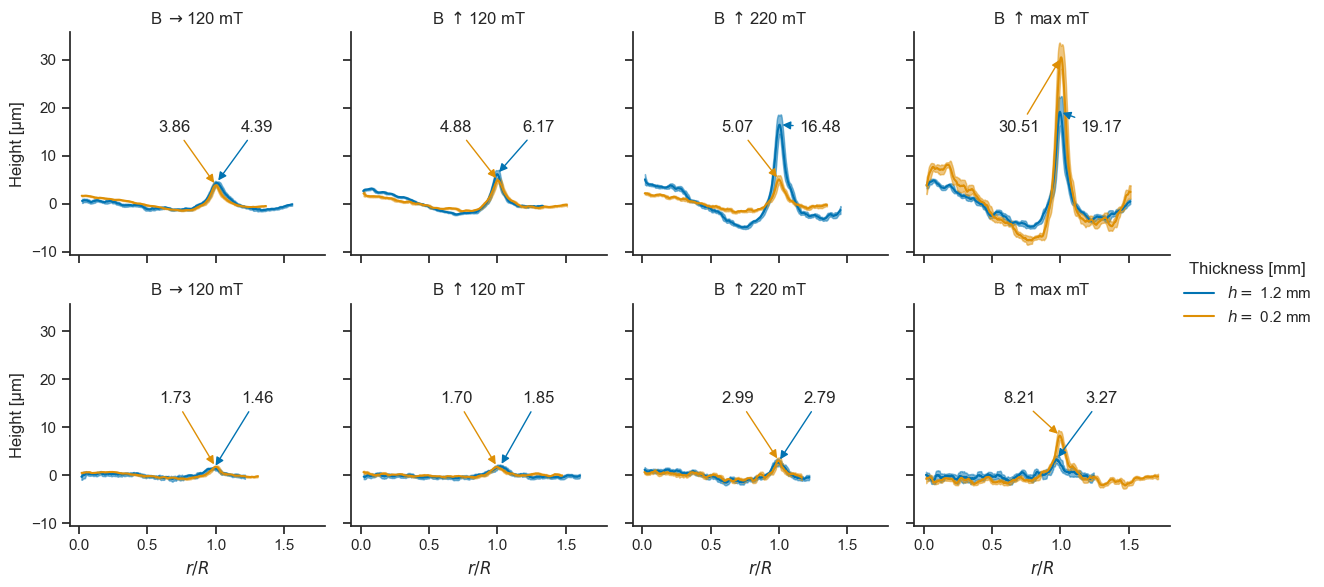

In [108]:
import seaborn as sns

def plot_nested_data(*args,**kwargs):
    color = kwargs.pop("color")
    data = kwargs.pop("data")
    x = np.asarray(data[args[0]].values[0])
    y = np.asarray(data[args[1]].values[0])
    rolling = pd.Series(y).rolling(25, center=True)
    y = rolling.mean()
    stdev_y = rolling.std()
    #
    plt.fill_between(x, y-stdev_y, y+stdev_y, alpha=0.5, color=color)
    plt.plot(x,y, color=color, **kwargs)
    if "label" in kwargs:
        # if kwargs["label"] == "0.2":
        #     plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="offset points", xytext=(15,10), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        # else:
        #     plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="offset points", xytext=(-15,10), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        if kwargs["label"] == "$h =$ 0.2 mm":
            plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="data", xytext=(0.7,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        else:
            plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="data", xytext=(1.3,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
    plt.legend()

grid = sns.FacetGrid(data=master_data, col="magn", row="G", hue="th", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
                     col_order= ["$\\rightarrow$120","$\\uparrow$120","$\\uparrow$220","$\\uparrow$max"],
                     row_order=["9.3 kPa","17.5 kPa"])

grid.set_titles(template="B {col_name} mT")
grid.map_dataframe(plot_nested_data, "norm_x", "y")
for info,ax in grid.axes_dict.items():
    if info[1] != "$\\rightarrow$120 mT": continue
    plt.sca(ax)
    plt.annotate(info[0], (-0.8, .5), xycoords="axes fraction", ha='center', va='center', fontsize=12, rotation=90)


# grid.figure.tight_layout()
grid.add_legend(title="Thickness [mm]" )
grid.set_xlabels("$r/R$")
grid.set_ylabels("Height [µm]")
grid.savefig(plot_out_dir / "ridge_profiles_comp.pdf")


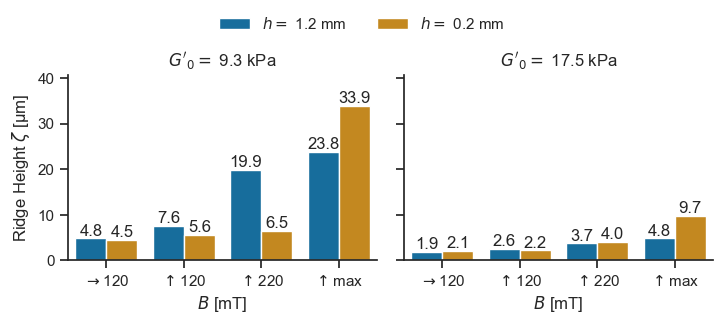

In [106]:
ordered_data = master_data.sort_values(by=["magn","G","th"], key=lambda x: x.map({"$\\rightarrow$120":0,"$\\uparrow$120":1,"$\\uparrow$220":2,"$\\uparrow$max":3}))


grid = sns.catplot(data=ordered_data, x="magn", y="peak_height", hue="th", col="G", kind="bar", sharey=True, aspect=1, height=3, legend_out=True, col_order=["9.3 kPa","17.5 kPa"])
# iterate through axes
for ax in grid.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        # add custom labels with the labels=labels parameter if needed
        labels = [f'{round(h,1):.1f}' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, label_type='edge', labels=labels)
    ax.margins(y=0.2)
# grid.figure.tight_layout()
# grid.legend.set_title("Thickness [mm]")
# legend on top
# grid.add_legend(title="Thickness [mm]", loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)
sns.move_legend(grid, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, title=None)
# grid.legend.set_title("Thickness [mm]")
grid.set_titles(col_template="$G'_0=$ {col_name}", row_template="")
grid.set_xlabels("$B$ [mT]")
grid.set_ylabels("Ridge Height $\\zeta$ [µm]")
plt.tight_layout()
grid.savefig(plot_out_dir / "peak_compare_magn.pdf")

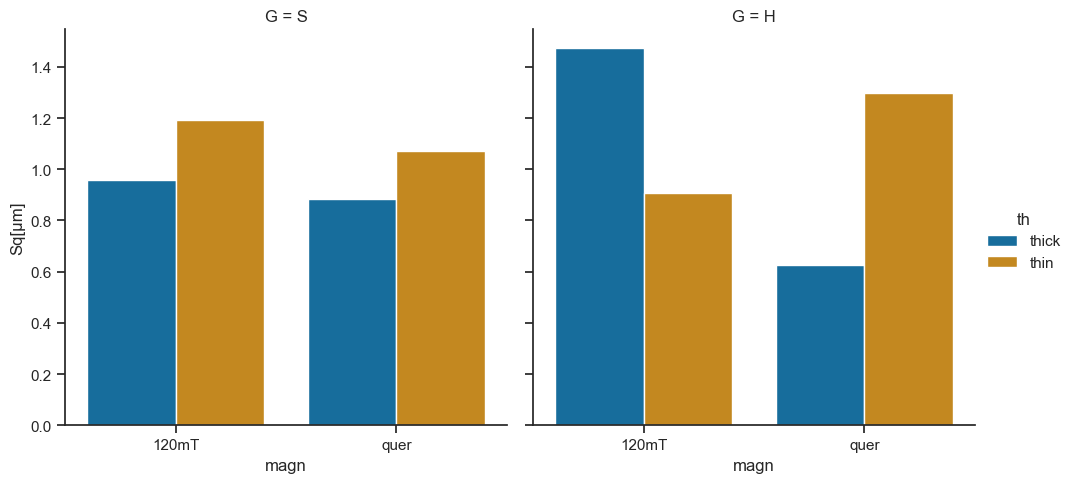

In [5]:
df = pd.read_csv(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\compare_quer_low_B\roughness_vert_vs_quer.csv", sep=",",header=0)

df["G"] = df["Dateiname"].str.split("_").str[1]
df["th"] = df["Dateiname"].str.split("_").str[3]
df["magn"] = df["Dateiname"].str.split("_").str[5]


sns.catplot(data=df, x="magn", y="Sq[μm]", col="G",  hue="th", kind="bar" )